In [1]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_800x800_20x20_%d.pkl'%(i) for i in range(1,51)]
import warnings
warnings.filterwarnings("ignore")
#####

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 51  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [5]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT = interp1d(L, cTgradT, kind='linear', bounds_error=False, fill_value=0.)

../data/input/universe_Planck15/camb/CAMB_outputs.pkl


In [6]:
powers['unlensed_scalar'].shape

(29901, 4)

In [7]:
cl.shape

(30001, 3)

In [8]:
# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [9]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [10]:
data = np.random.normal(loc=0., 
                        scale=1./np.sqrt(baseMap.dX*baseMap.dY), 
                        size=len(baseMap.x.flatten()))

data = data.reshape(np.shape(baseMap.x))

dataFourier = baseMap.fourier(data)

dataFourier = np.ones_like(dataFourier)
f = lambda l: np.sqrt(cmb.fCtotal(l))
clFourier = np.array(list(map(f, baseMap.l.flatten())))
clFourier = np.nan_to_num(clFourier)
clFourier = clFourier.reshape(np.shape(baseMap.l))

dataFourier *= clFourier * np.sqrt(baseMap.sizeX* baseMap.sizeY)
TRand = baseMap.randomizePhases(dataFourier=dataFourier)

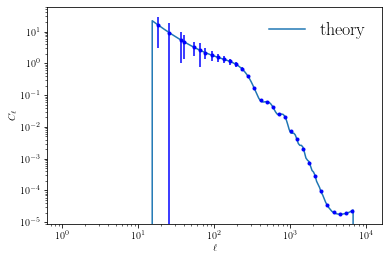

In [11]:
baseMap.powerSpectrum(TRand, 
                      theory=[cmb.fCtotal], 
                      plot=True);

In [12]:
TRand2 = baseMap.randomizePhases(dataFourier=dataFourier)

In [13]:
from multiprocessing import Pool
from tqdm import tqdm
import numpy as np

def process_data(_):
    TRand = baseMap.randomizePhases(dataFourier=dataFourier)
    sqrtNhat = baseMap.computeQuadEstKappaAutoCorrectionMap(fTgradT,
                                                            cmb.fCtotal, 
                                                            lMin=lMin, lMax=lMax, 
                                                            dataFourier=TRand)
    return sqrtNhat

with Pool() as p:
    res = list(tqdm(p.imap(process_data, range(500)), total=500))
c_data = np.array(res)

100%|██████████| 500/500 [03:47<00:00,  2.20it/s]


In [14]:
data = {}
data['sqrtN'] = c_data
ps_data = {}

In [15]:
#estimate Nhat
ck = 'Nhat TTRand'
nBins=51
for data_idx in trange(len(data['sqrtN'])):
    sqrtNhat = data['sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck],np.array([c_ps_data[ck]])))  
        
print(ps_data[ck].shape)

100%|██████████| 500/500 [00:07<00:00, 65.24it/s]

(500, 3, 50)


In [16]:
pairs = [
#    [0,0], #N0
#    [0,1], #kappa
#    [1,0], #kappa
#    [0,2], #N1
#    [1,1], #N1
#    [2,0], #N1
#     [0,3], #should vanish
#     [1,2], #should vanish
#     [2,1], #should vanish
#     [3,0], #should vanish
#     [0,4], #N2 
#     [1,3], #N2
#     [2,2], #N2
#     [3,1], #N2
#     [4,0], #N2
   [-1, -1], #QE
   [-2, -2], #unlensed
]

# random seed
# Nhat <TTTT> look at to see if its subtract (11)
# compute (B12)
data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    3: 'lCmbF_o3_1',
    4: 'lCmbF_o4_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}

# pbar = trange(len(pairs))
for file_idx in trange(1,51):
    for pair_idx in range(len(pairs)):
        pair = pairs[pair_idx]
        c_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/QE_and_Nhat_from_map_sims_800x800_20x20_FILE%d_pair_%d_%d.pkl'%(file_idx, pair[0], pair[1])
        if(not os.path.isfile(c_fname)):
            continue
        f = open(c_fname, 'rb')  
        c_data = pickle.load(f)
        f.close()        
        for key in c_data:
            if(key not in data.keys()):
                data[key] = np.array(c_data[key])
            else:
                data[key] = np.vstack((data[key], np.array(c_data[key])))  
#             print(np.shape(data[key]))

100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


In [17]:
print(data.keys())

dict_keys(['sqrtN', '-1-1', '-1-1_sqrtN', '-2-2', '-2-2_sqrtN'])


In [18]:
#estimate Nhat
ck = 'Nhat'
for data_idx in trange(len(data['-1-1_sqrtN'])):
    sqrtNhat = data['-1-1_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck],np.array([c_ps_data[ck]])))  
        
print(ps_data[ck].shape)

100%|██████████| 500/500 [00:07<00:00, 64.73it/s]

(500, 3, 50)


In [19]:
#estimate GRF Nhat
ck = 'GRF'
for data_idx in trange(len(data['-2-2_sqrtN'])):
    sqrtNhat = data['-2-2_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

100%|██████████| 500/500 [00:07<00:00, 65.11it/s]


In [20]:
#estimate GRF Nhat
ck = 'GRF havled'
for data_idx in trange(len(data['-2-2_sqrtN'])//2):
    sqrtNhat = data['-2-2_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

100%|██████████| 250/250 [00:04<00:00, 61.11it/s]


In [21]:
ps_data.keys()

dict_keys(['Nhat TTRand', 'Nhat', 'GRF', 'GRF havled'])

In [22]:
import numpy as np
from multiprocessing import Pool
from tqdm import trange

# Define a function to compute Ntheory_evaled for a given iteration
def compute_Ntheory_evaled(_):
    # Replace your original code here
    t0, t1 = baseMap.binTheoryPowerSpectrum(Ntheory, nBins=nBins)
    t2 = np.zeros_like(t1)
    return [t0, t1, t2]

# Set the number of iterations for parallel processing
num_iterations = ps_data['Nhat'].shape[0]

# Create a pool of worker processes using all available CPU cores
pool = Pool()

# Use the map function to parallelize the computation of Ntheory_evaled
Ntheory_evaled = list(tqdm(pool.imap(compute_Ntheory_evaled, range(num_iterations)), total=num_iterations))

# Convert the list of results to a NumPy array
Ntheory_evaled = np.array(Ntheory_evaled)

# Clean up the pool of worker processes
pool.close()
pool.join()

100%|██████████| 500/500 [01:10<00:00,  7.08it/s]


In [23]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
#     sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    sCls = np.std(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/np.sqrt(n_runs)

    return lCen, Cls, sCls

500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)


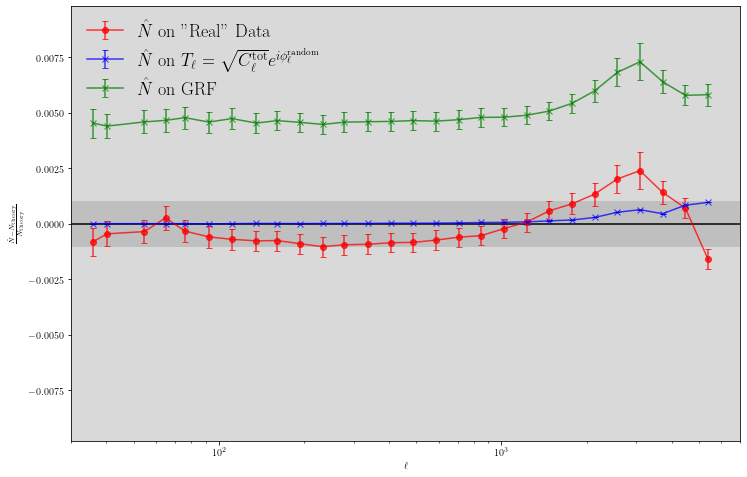

In [24]:
offset=0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(12,8))


plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

ell = baseMap.l.flatten()

lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['Nhat']))
lCen1, Cl1, sCl1 = combine_Cl(Ntheory_evaled)



# print((Cl0-Cl1)/Cl0)
assert(all(lCen0 == lCen1))
ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='o-', capsize=3, capthick=1, c='red', label=r'$\hat N$ on "Real" Data')#, label=labels[key], c=colors[key])



lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['Nhat TTRand']))
ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='x-', capsize=3, capthick=1, c='blue', label=r'$\hat N$ on $T_\ell = \sqrt{C_\ell^{\rm tot}} e^{i\phi_\ell^{\rm random}}$')#, label=labels[key], c=colors[key])

lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF']))
ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='x-', capsize=3, capthick=1, c='Green', label=r'$\hat N$ on GRF')#, label=labels[key], c=colors[key])

# lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF havled']))
# ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
#             fmt='x-', capsize=3, capthick=1, c='lightgreen', label=r'$\hat N$ on GRF [Halved Stats]')#, label=labels[key], c=colors[key])


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\hat N-N_{\rm theory}}{N_{\rm theory}}$')

# ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
# ax.set_ylim(1.1e-10,.9e-3)

ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
ax.fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.75')#, label=r'$<1\%$ Error')

# ax.set_yscale('symlog', linthresh=.5e-2) 

ax.axhline(0, c='k')

ax.set_ylim(-.98e-2, .98e-2)
ax.legend(frameon=False)
# ax.set_yticks([-1e-1,-1e-2,-1e-3,1e-1,1e-2,1e-3])
plt.savefig('figures/Nhat various.pdf')

In [253]:
tmp_norm = baseMap.computeQuadEstPhiNormalizationFFT(fTgradT, cmb.fCtotal)

tmp_norm = np.real(tmp_norm)
# remove the nans
tmp_norm = np.nan_to_num(tmp_norm)
# make sure every value is positive
tmp_norm = np.abs(tmp_norm)

In [169]:
lnorm, normps, _ = baseMap.powerSpectrum(tmp_norm)

In [170]:
fnorm = interp1d(lnorm, normps, kind='linear', bounds_error=False, fill_value=0.)

In [263]:
fnorm = baseMap.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax)

computing the reconstruction noise


(7e-08, 1e-06)

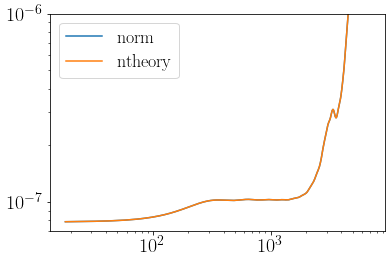

In [264]:
plt.plot(L, np.array(list(map(fnorm, L))), label='norm')
plt.plot(L, list(map(Ntheory,L)),label='ntheory')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim([7e-8,1e-6])

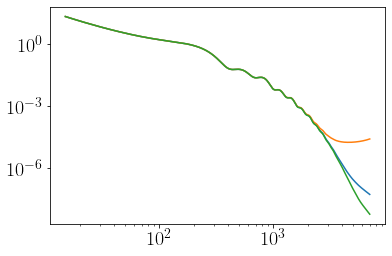

In [107]:
plt.plot(L, list(map(flensedTT, L)))
plt.plot(L, list(map(ftot,L)))
plt.plot(L, list(map(fTgradT,L)))

plt.xscale('log')
plt.yscale('log')

We showed in the paper tthat Nhat(GRF) should be biased by
$${\rm correction} = 2 N_{\rm theory}^2 F_{L/2, L/2}^2 (C_{L/2}^{\rm tot})^2$$

$$F_{L/2, L/2} = \frac{f_{L/2, L/2}}{2 (C_{L/2}^{\rm tot})^2}$$
$$f_{L/2, L/2} = 2/(L)^2 \times (L)\cdot L C_{L/2}^{T\nabla T}=2 C_{L/2}^{T\nabla T}$$

$$F_{L/2, L/2} = \frac{ C_{L/2}^{T\nabla T}}{ (C_{L/2}^{\rm tot})^2}$$

$${\rm correction} = 2 N_{\rm theory}^2 \times  \frac{(C_{L/2}^{T\nabla T})^2}{ (C_{L/2}^{\rm tot})^2}  $$

In [213]:
correctionTMP = lambda L: 2*Ntheory(L)**2*fTgradT(L/2)**2 / ftot(L/2)**2  * (2*np.pi)**4

In [265]:
correction = lambda L: 2*fnorm(L)**2*fTgradT(L/2)**2 / ftot(L/2)**2  * (2*np.pi)**4 

500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)
[       nan        nan        nan        nan        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf 0.00024467        inf 0.00024524
        inf 0.00024628 0.00024681 0.00024892 0.0002508  0.00025311
 0.00025706 0.0002624  0.00027019 0.00027896 0.00029048 0.00030325
 0.00031362 0.00031928 0.00031831 0.00031714 0.00032044 0.00031968
 0.00031824 0.0003196  0.00031934 0.00031979 0.00032818 0.00035872
 0.00043878 0.00077494 0.00076381 0.00172453 0.00682899 0.
        nan        nan]
500 (500, 3, 50)


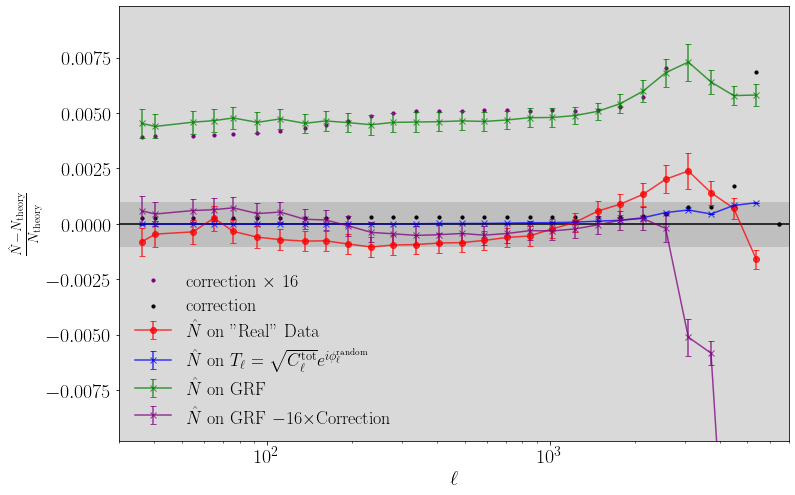

In [270]:
offset=0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(12,8))


plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

ell = baseMap.l.flatten()

lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['Nhat']))
lCen1, Cl1, sCl1 = combine_Cl(Ntheory_evaled)



# print((Cl0-Cl1)/Cl0)
assert(all(lCen0 == lCen1))
ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='o-', capsize=3, capthick=1, c='red', label=r'$\hat N$ on "Real" Data')#, label=labels[key], c=colors[key])



lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['Nhat TTRand']))
ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='x-', capsize=3, capthick=1, c='blue', label=r'$\hat N$ on $T_\ell = \sqrt{C_\ell^{\rm tot}} e^{i\phi_\ell^{\rm random}}$')#, label=labels[key], c=colors[key])

lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF']))
ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='x-', capsize=3, capthick=1, c='Green', label=r'$\hat N$ on GRF')#, label=labels[key], c=colors[key])

# lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF havled']))
# ax.errorbar(lCen0, (Cl0-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
#             fmt='x-', capsize=3, capthick=1, c='lightgreen', label=r'$\hat N$ on GRF [Halved Stats]')#, label=labels[key], c=colors[key])

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\hat N-N_{\rm theory}}{N_{\rm theory}}$')

# ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
# ax.set_ylim(1.1e-10,.9e-3)

ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
ax.fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.75')#, label=r'$<1\%$ Error')


corr = np.array(list(map(correction, lCen0)))
print((corr)/Cl1)
plt.scatter(lCen0, (16)*(corr)/Cl1, label=r'correction $\times$ 16', c='purple', s=10)
plt.scatter(lCen0, (corr)/Cl1, label='correction', c='k', s=10)


lCen0, Cl0, sCl0 = combine_Cl(np.array(ps_data['GRF']))
ax.errorbar(lCen0, (Cl0-16*corr-Cl1)/(Cl1), yerr=sCl0/Cl1, alpha=0.75, 
            fmt='x-', capsize=3, capthick=1, c='purple', label=r'$\hat N$ on GRF $-16\times$Correction')#, label=labels[key], c=colors[key])

# ax.set_yscale('symlog', linthresh=.5e-2) 

ax.axhline(0, c='k')

ax.set_ylim(-.98e-2, .98e-2)
ax.legend(frameon=False)
# ax.set_yticks([-1e-1,-1e-2,-1e-3,1e-1,1e-2,1e-3])
# plt.savefig('figures/Nhat various.pdf')

## aliasing issue?

In [271]:
np.max(baseMap.lx)

7200.0

In [272]:
4*lMax

14000.0

In [273]:
7200/4

1800.0